# Evaluate Classifier Predictions

**Gregory Way, 2018**

In the following notebook I evaluate the predictions made by the Ras, _NF1_, and _TP53_ classifiers in the input PDX RNAseq data.

## Procedure

1. Load status matrices
  * These files store the mutation status for _TP53_ and Ras pathway genes for the input samples
2. Align barcode identifiers
  * The identifiers matching the RNAseq data to the status matrix are not aligned.
  * I use an intermediate dictionary to map common identifiers
3. Load predictions (see `1.apply-classifier.ipynb` for more details)
4. Evaluate predictions
  * I visualize the distribution of predictions between wild-type and mutant samples for both classifiers

## Output

The output of this notebook are several evaluation figures demonstrating the predictive performance on the input data for the three classifiers. Included in this output are predictions stratified by histology.

In [1]:
import os
import random
from decimal import Decimal
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve

import seaborn as sns
import matplotlib.pyplot as plt

from utils import get_mutant_boxplot, perform_ttest

In [2]:
%matplotlib inline

In [3]:
np.random.seed(123)

## Load Status Matrix

In [4]:
file = os.path.join('data', 'raw', '2019-02-14-ras-tp53-nf1-alterations.txt')
status_df = pd.read_table(file)

print(status_df.shape)
status_df.head(3)

(258, 21)


,Model,TSB,Hugo_Symbol,classifier,Chromosome,Start_position,End_position,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,...,Variant_Type,cDNA_Change,Protein_Change,VAF,dbNSFP_SIFT_pred,Histology.Detailed,Fusion,Have.snp.file,Have.maf,Have.fpkm.file
0,ALL-03,TARGET-10-PPT086-60A-01D-human,ALK,ras,2.0,30143482.0,30143482.0,G,G,T,...,SNP,c.44C>A,p.S15Y,0.444444,.,MLL-ALL,NaN,yes,yes,yes
1,ALL-03,TARGET-10-PPT086-60A-01D-human,ALK,ras,2.0,30143477.0,30143477.0,C,C,T,...,SNP,c.49G>A,p.A17T,0.470588,.,MLL-ALL,NaN,yes,yes,yes
2,ALL-07,TARGET-10-PPT088-60A-01D-human,KRAS,ras,12.0,25398284.0,25398284.0,C,C,A,...,SNP,c.35G>T,p.G12V,0.425926,D,BCP-ALL,NaN,yes,yes,yes


In [5]:
status_df.Hugo_Symbol.value_counts()

TP53      76
CDKN2A    64
ALK       18
RB1       17
KRAS      16
NF1       13
ATM       11
NRAS      10
ATR        7
MDM2       5
CHEK2      5
HRAS       4
PTPN11     4
CHEK1      3
BRAF       3
GORAB      2
Name: Hugo_Symbol, dtype: int64

In [6]:
status_df.Variant_Classification.value_counts()

Missense_Mutation      120
Homozygous_Deletion     67
Hemizygous_Deletion     19
Nonsense_Mutation       14
Fusion                  14
Frame_Shift_Del          7
Frame_Shift_Ins          6
Amplification            6
Splice_Site              3
In_Frame_Del             2
Name: Variant_Classification, dtype: int64

In [7]:
pd.crosstab(status_df['Histology.Detailed'], status_df.Hugo_Symbol)

Hugo_Symbol,ALK,ATM,ATR,BRAF,CDKN2A,CHEK1,CHEK2,GORAB,HRAS,KRAS,MDM2,NF1,NRAS,PTPN11,RB1,TP53
Histology.Detailed,,,,,,,,,,,,,,,,
ASPS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
ATRT,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Astrocytoma,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,1
BCP-ALL,0,2,2,0,17,1,1,1,1,10,0,1,6,0,1,4
Colon Carcinoma,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
ETMR,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
ETP-ALL,0,1,0,0,2,0,0,0,0,0,0,0,0,1,0,0
Ependymoma,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Ewing Sarcoma,0,0,1,0,6,0,0,0,1,0,1,0,0,0,0,7


In [8]:
# Obtain a binary status matrix
full_status_df = pd.crosstab(status_df['Model'], status_df.Hugo_Symbol)
full_status_df[full_status_df > 1] = 1
full_status_df = full_status_df.reset_index()

In [9]:
histology_df = status_df.loc[:, ['Model', 'Histology.Detailed']]
histology_df.columns = ['Model', 'Histology_Full']

full_status_df = (
    full_status_df
    .merge(histology_df, how='left', on="Model")
    .drop_duplicates()
    .reset_index(drop=True)
)

print(full_status_df.shape)
full_status_df.head()

(161, 18)


,Model,ALK,ATM,ATR,BRAF,CDKN2A,CHEK1,CHEK2,GORAB,HRAS,KRAS,MDM2,NF1,NRAS,PTPN11,RB1,TP53,Histology_Full
0,ALL-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,BCP-ALL
1,ALL-03,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,MLL-ALL
2,ALL-04,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Ph+-ALL
3,ALL-07,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,BCP-ALL
4,ALL-08,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,T-ALL


## Extract Gene Status

In [10]:
# Ras Pathway Alterations
ras_genes = ['KRAS', 'HRAS', 'NRAS']
tp53_genes = ["TP53"]
nf1_genes = ["NF1"]

full_status_df = (
    full_status_df
    .assign(ras_status = full_status_df.loc[:, ras_genes].sum(axis=1),
            tp53_status = full_status_df.loc[:, tp53_genes].sum(axis=1),
            nf1_status = full_status_df.loc[:, nf1_genes].sum(axis=1))
    
)

full_status_df.head()

,Model,ALK,ATM,ATR,BRAF,CDKN2A,CHEK1,CHEK2,GORAB,HRAS,...,MDM2,NF1,NRAS,PTPN11,RB1,TP53,Histology_Full,nf1_status,ras_status,tp53_status
0,ALL-02,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,BCP-ALL,0,0,0
1,ALL-03,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,MLL-ALL,0,0,0
2,ALL-04,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,Ph+-ALL,0,0,0
3,ALL-07,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,BCP-ALL,0,1,0
4,ALL-08,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,T-ALL,0,0,0


## Load Clinical Data Information

This stores histology information

In [11]:
file = os.path.join('data', 'raw', 'pptc-pdx-clinical-web.txt')
clinical_df = pd.read_table(file)

print(clinical_df.shape)
clinical_df.head(3)

(261, 32)


,Model,Phase,PersonID,DNA.Part.of.PPTC,RNA.Part.of.PPTC,Have.snp.file,snp.array.filename,snp.array.sample.ID,Have.maf,WES.human.bam.filename,...,Histology.Oncoprints2,STR.OK,Model.Type,Histology,Histology.Detailed,PI,Sex,Age,Reported_Ethnicity,Inferred_Ethnicity
0,ALL-02,Relapse,P0001,yes,yes,yes,PPTC-ALL-02-D-1.SNPFinalReports.txt,PPTC-ALL-02-D,yes,TARGET-10-PPT085-60A-01D-human.bam,...,BCP-ALL,Yes,PDX,ALL,BCP-ALL,Lock,Female,5.42,Unknown,Mixed_or_Unknown
1,ALL-03,Diagnosis,P0002,yes,yes,yes,PPTC-ALL-03-D-1.SNPFinalReports.txt,PPTC-ALL-03-D,yes,TARGET-10-PPT086-60A-01D-human.bam,...,MLL-ALL,"Yes, discrepancy in vWA",PDX,ALL,MLL-ALL,Lock,Female,12.92,Unknown,European
2,ALL-04,Diagnosis,P0003,yes,yes,yes,PPTC-ALL-04-D-1.SNPFinalReports.txt,PPTC-ALL-04-D,yes,TARGET-10-PPT087-60A-02D-human.bam,...,Ph+ or Ph-like-ALL,Yes,PDX,ALL,Ph+-ALL,Lock,Male,8.67,Unknown,European


## Load Predictions and Merge with Clinical and Alteration Data

In [12]:
file = os.path.join('results', 'classifier_scores.tsv')
scores_df = pd.read_table(file)

scores_df = (
    scores_df.merge(
        clinical_df,
        how='left', left_on='sample_id', right_on='Model'
    )
    .merge(
        full_status_df,
        how='left', left_on='sample_id', right_on='Model'
    )
)

print(scores_df.shape)
scores_df.head()

(244, 60)


,sample_id,ras_score,tp53_score,nf1_score,ras_shuffle,tp53_shuffle,nf1_shuffle,Model_x,Phase,PersonID,...,MDM2,NF1,NRAS,PTPN11,RB1,TP53,Histology_Full,nf1_status,ras_status,tp53_status
0,ALL-102,0.524098,0.430674,0.504012,0.578858,0.371647,0.557121,ALL-102,Diagnosis,P0007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ALL-105,0.417246,0.505113,0.442152,0.315399,0.302545,0.425273,ALL-105,Relapse,P0007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ALL-106,0.446739,0.342593,0.409099,0.529298,0.653105,0.419371,ALL-106,Diagnosis,P0008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALL-107,0.368172,0.418647,0.449422,0.503032,0.497139,0.467002,ALL-107,Diagnosis,P0009,...,0.0,0.0,0.0,0.0,0.0,0.0,Ph-likeALL,0.0,0.0,0.0
4,ALL-108,0.438261,0.450736,0.446484,0.528116,0.501936,0.515667,ALL-108,Diagnosis,P0010,...,0.0,0.0,0.0,0.0,0.0,0.0,Ph-likeALL,0.0,1.0,0.0


In [13]:
gene_status = ['tp53_status', 'ras_status', 'nf1_status']
scores_df.loc[:, gene_status] = (
    scores_df.loc[:, gene_status].fillna(0)
)

scores_df.loc[scores_df['tp53_status'] != 0, 'tp53_status'] = 1
scores_df.loc[scores_df['ras_status'] != 0, 'ras_status'] = 1
scores_df.loc[scores_df['nf1_status'] != 0, 'nf1_status'] = 1

scores_df['tp53_status'] = scores_df['tp53_status'].astype(int)
scores_df['ras_status'] = scores_df['ras_status'].astype(int)
scores_df['nf1_status'] = scores_df['nf1_status'].astype(int)

scores_df.head(2)

,sample_id,ras_score,tp53_score,nf1_score,ras_shuffle,tp53_shuffle,nf1_shuffle,Model_x,Phase,PersonID,...,MDM2,NF1,NRAS,PTPN11,RB1,TP53,Histology_Full,nf1_status,ras_status,tp53_status
0,ALL-102,0.524098,0.430674,0.504012,0.578858,0.371647,0.557121,ALL-102,Diagnosis,P0007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,ALL-105,0.417246,0.505113,0.442152,0.315399,0.302545,0.425273,ALL-105,Relapse,P0007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


## Load Histology Color Codes

In [14]:
file = os.path.join('data', '2019-07-09-all-hist-colors.txt')
color_code_df = pd.read_csv(file)
color_code_df.head(2)

,Histology,Color
0,ATRT,#000000
1,Wilms,#007EB5


In [15]:
color_dict = dict(zip(color_code_df.Histology, color_code_df.Color))
color_dict

{'ASPS': '#DAF1FC',
 'ATRT': '#000000',
 'Astrocytoma': '#ED2891',
 'BCP-ALL': '#97D1A9',
 'CNS EFT-CIC': '#7E1918',
 'CNS embryonal NOS': '#F9ED32',
 'CNS germinoma': '#00A99D',
 'Clear Cell Sarcoma': '#F6B667',
 'Colon Carcinoma': '#F89420',
 'DIPG': '#A084BD',
 'ETMR': '#CACCDB',
 'ETP-ALL': '#754C29',
 'Ependymoblastoma': '#D97D25',
 'Ependymoma': '#C1A72F',
 'Ewing Sarcoma': '#542C88',
 'Ewing_Sarcoma': '#542C88',
 'Extracranial Rhabdoid': '#9EDDF9',
 'Fusion+ RMS': '#E8C51D',
 'Fusion- RMS': '#00AEEF',
 'Fusion-_RMS': '#00AEEF',
 'Glioblastoma': '#B2509E',
 'Hepatoblastoma': '#104A7F',
 'MB-Group3': '#F8AFB3',
 'MB-Group4': '#ED1C24',
 'MB-SHH': '#FBE3C7',
 'MB-Unclassified': '#D49DC7',
 'MB-WNT': '#FAD2D9',
 'MLL-ALL': '#009444',
 'Neuroblastoma': '#EA7075',
 'Osteosarcoma': '#6E7BA2',
 'PF-EPN-A': '#43CD80',
 'PF-EPN-B': '#FF7256',
 'Ph+-ALL': '#3953A4',
 'Ph-likeALL': '#BE1E2D',
 'ST-EPN-RELA': '#C1A72F',
 'ST-EPN-YAP1': '#836FFF',
 'Small Cell Carcinoma': '#D3C3E0',
 'T-ALL':

## Determine Status Counts

In [16]:
scores_df.tp53_status.value_counts()

0    184
1     60
Name: tp53_status, dtype: int64

In [17]:
scores_df.ras_status.value_counts()

0    214
1     30
Name: ras_status, dtype: int64

In [18]:
scores_df.nf1_status.value_counts()

0    233
1     11
Name: nf1_status, dtype: int64

## Perform ROC and Precision-Recall Analysis using all Alteration Information

In [19]:
n_classes = 3
labels = ['Ras', 'NF1', 'TP53']
colors = ['#1b9e77', '#d95f02', '#7570b3']

fpr_pdx = {}
tpr_pdx = {}
thresh_pdx = {}
precision_pdx = {}
recall_pdx = {}
auroc_pdx = {}
aupr_pdx = {}

fpr_shuff = {}
tpr_shuff = {}
thresh_shuff = {}
precision_shuff = {}
recall_shuff = {}
auroc_shuff = {}
aupr_shuff = {}

all_roc_list = []

idx = 0
for status, score, shuff in zip(('ras_status', 'nf1_status', 'tp53_status'),
                                ('ras_score', 'nf1_score', 'tp53_score'),
                                ('ras_shuffle', 'nf1_shuffle', 'tp53_shuffle')):
    
    # Obtain Metrics
    sample_status = scores_df.loc[:, status]
    sample_score = scores_df.loc[:, score]
    shuffle_score = scores_df.loc[:, shuff]
 
    # Get Metrics
    fpr_pdx[idx], tpr_pdx[idx], thresh_pdx[idx] = roc_curve(sample_status, sample_score, drop_intermediate=False)
    precision_pdx[idx], recall_pdx[idx], _ = precision_recall_curve(sample_status, sample_score)
    auroc_pdx[idx] = roc_auc_score(sample_status, sample_score)
    aupr_pdx[idx] = average_precision_score(sample_status, sample_score)
    
    # Obtain Shuffled Metrics
    fpr_shuff[idx], tpr_shuff[idx], thresh_shuff[idx] = roc_curve(sample_status, shuffle_score, drop_intermediate=False)
    precision_shuff[idx], recall_shuff[idx], _ = precision_recall_curve(sample_status, shuffle_score)
    auroc_shuff[idx] = roc_auc_score(sample_status, shuffle_score)
    aupr_shuff[idx] = average_precision_score(sample_status, shuffle_score)
    
    roc_df = (
        pd.DataFrame([fpr_pdx[idx], tpr_pdx[idx], thresh_pdx[idx]], index=['fpr', 'tpr', 'threshold'])
        .transpose()
        .assign(gene=labels[idx],
                shuffled=False)
    )
    
    roc_shuffled_df = (
    pd.DataFrame([fpr_shuff[idx], tpr_shuff[idx], thresh_shuff[idx]], index=['fpr', 'tpr', 'threshold'])
    .transpose()
    .assign(gene=labels[idx],
            shuffled=True)
    )
    
    all_roc_list.append(roc_df)
    all_roc_list.append(roc_shuffled_df)

    idx += 1

In [20]:
os.makedirs('figures', exist_ok=True)

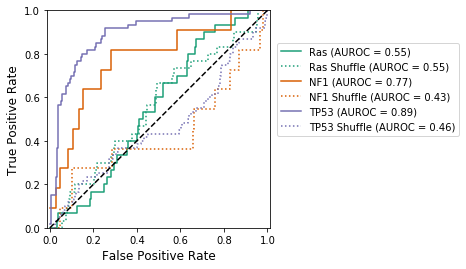

In [21]:
# Visualize ROC curves
plt.subplots(figsize=(4, 4))

for i in range(n_classes):
    plt.plot(fpr_pdx[i], tpr_pdx[i],
             label='{} (AUROC = {})'.format(labels[i], round(auroc_pdx[i], 2)),
             linestyle='solid',
             color=colors[i])

    # Shuffled Data
    plt.plot(fpr_shuff[i], tpr_shuff[i],
             label='{} Shuffle (AUROC = {})'.format(labels[i], round(auroc_shuff[i], 2)),
             linestyle='dotted',
             color=colors[i])

plt.axis('equal')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

plt.tick_params(labelsize=10)

lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

file = os.path.join('figures', 'classifier_roc_curve.pdf')
plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight')

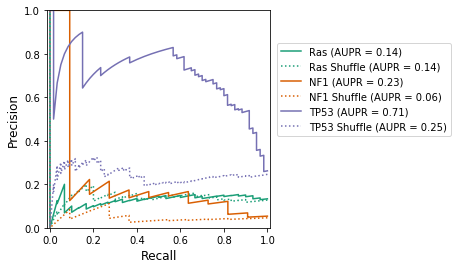

In [22]:
# Visualize PR curves
plt.subplots(figsize=(4, 4))

for i in range(n_classes):
    plt.plot(recall_pdx[i], precision_pdx[i],
             label='{} (AUPR = {})'.format(labels[i], round(aupr_pdx[i], 2)),
             linestyle='solid',
             color=colors[i])
    
    # Shuffled Data
    plt.plot(recall_shuff[i], precision_shuff[i],
             label='{} Shuffle (AUPR = {})'.format(labels[i], round(aupr_shuff[i], 2)),
             linestyle='dotted',
             color=colors[i])

plt.axis('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)

plt.tick_params(labelsize=10)

lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

file = os.path.join('figures', 'classifier_precision_recall_curve.pdf')
plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight')

## Perform t-test against status classification

In [23]:
t_results_ras = perform_ttest(scores_df, gene='ras')
t_results_ras

Ttest_indResult(statistic=0.98221843766134, pvalue=0.3309784211310528)

In [24]:
t_results_nf1 = perform_ttest(scores_df, gene='nf1')
t_results_nf1

Ttest_indResult(statistic=2.7967058658873927, pvalue=0.01814575749239107)

In [25]:
t_results_tp53 = perform_ttest(scores_df, gene='tp53')
t_results_tp53

Ttest_indResult(statistic=12.385486996369536, pvalue=7.676919512114478e-23)

## Observe broad differences across sample categories

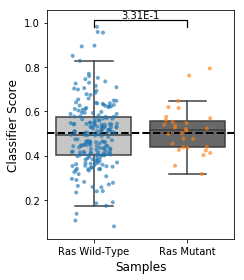

In [26]:
# Ras
get_mutant_boxplot(df=scores_df,
                   gene="Ras",
                   t_test_results=t_results_ras)

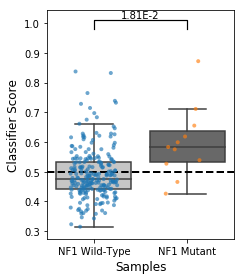

In [27]:
# NF1
get_mutant_boxplot(df=scores_df,
                   gene="NF1",
                   t_test_results=t_results_nf1)

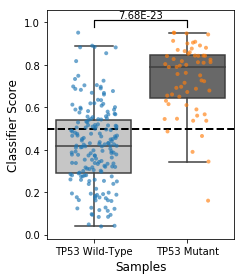

In [28]:
# TP53
get_mutant_boxplot(df=scores_df,
                   gene="TP53",
                   t_test_results=t_results_tp53)

## Write output files for downstream analysis

In [29]:
# Classifier scores with clinical data and alteration status
scores_file = os.path.join("results", "classifier_scores_with_clinical_and_alterations.tsv")
genes = ras_genes + ['TP53']

scores_df = scores_df.drop(['Model_x', 'Model_y', 'Histology_Full'], axis='columns')
scores_df[genes] = scores_df[genes].fillna(value=0)

scores_df.sort_values(by='sample_id').to_csv(scores_file, sep='\t', index=False)

In [30]:
# Output classifier scores for the specific variants observed
status_scores_file = os.path.join("results", "classifier_scores_with_variants.tsv")

classifier_scores_df = scores_df[['sample_id', 'ras_score' ,'tp53_score', 'nf1_score', 'Histology.Detailed']]
classifier_scores_df = (
    status_df
    .drop(['Histology.Detailed'], axis='columns')
    .merge(classifier_scores_df, how='left', left_on='Model', right_on='sample_id')
)

classifier_scores_df.sort_values(by='Model').to_csv(status_scores_file, sep='\t', index=False)

In [31]:
# ROC Curve Estimates
file = os.path.join("results", "full_roc_threshold_results.tsv")

full_roc_df = pd.concat(all_roc_list, axis='rows')
full_roc_df.to_csv(file, sep='\t', index=False)